In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import shutil
from keras import applications
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from tqdm import tqdm_notebook
from keras.layers import Conv2DTranspose
from keras.layers.merge import concatenate, add
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage.transform import resize
from keras import backend as keras


import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

IMG_WIDTH = 512
IMG_HEIGHT = 512

BATCH_SIZE = 8

DATA_PATH = ".\\dataset\\MontgomerySet"
CXR_PNG = os.path.join(DATA_PATH, 'CXR_png')

FRAME_PATH = os.path.join(DATA_PATH, "images_grayscale")
LEFT_MASK_PATH = os.path.join(DATA_PATH, "ManualMask\\leftMask")
RIGHT_MASK_PATH = os.path.join(DATA_PATH, "ManualMask\\rightMask")

TRAIN_FRAME_PATH = os.path.join(DATA_PATH, 'train_frames')
TRAIN_MASK_PATH = os.path.join(DATA_PATH, 'train_masks')
TEST_FRAME_PATH = os.path.join(DATA_PATH, 'test_frames')
TEST_MASK_PATH = os.path.join(DATA_PATH, 'test_masks')

#tf.enable_eager_execution()

Using TensorFlow backend.


In [67]:
def mergeMasks():
    
    cases = [[TRAIN_FRAME_PATH, TRAIN_MASK_PATH], [TEST_FRAME_PATH, TEST_MASK_PATH]]
    
    for case in cases:
        for file in os.listdir(case[0]):
            left_mask = cv2.imread(os.path.join(LEFT_MASK_PATH, file), cv2.IMREAD_GRAYSCALE)
            right_mask = cv2.imread(os.path.join(RIGHT_MASK_PATH, file), cv2.IMREAD_GRAYSCALE)

            left_mask = cv2.resize(left_mask, (IMG_WIDTH, IMG_HEIGHT))
            right_mask = cv2.resize(right_mask, (IMG_WIDTH, IMG_HEIGHT))

            merged = np.maximum(left_mask, right_mask)
            cv2.imwrite(os.path.join(case[1], file), merged)
        
def initDataForTraining():

    folders = ['train_frames', 'train_masks', 'val_frames', 'val_masks', 'test_frames', 'test_masks']
    
    for folder in folders:
        if(not os.path.exists(os.path.join(DATA_PATH, folder))):
            os.makedirs(os.path.join(DATA_PATH, folder))
    
    all_frames = os.listdir(FRAME_PATH)
    random.shuffle(all_frames)
    split = int(0.7*len(all_frames))

    train = all_frames[:split]
    test = all_frames[split:]
    
    if(os.listdir(os.path.join(DATA_PATH, 'train_frames')) == []):
        for fileName in train:
            shutil.copy(os.path.join(FRAME_PATH, fileName), os.path.join(DATA_PATH, 'train_frames'))
            shutil.copy(os.path.join(LEFT_MASK_PATH, fileName), os.path.join(DATA_PATH, 'train_masks'))

        for fileName in test:
            shutil.copy(os.path.join(FRAME_PATH, fileName), os.path.join(DATA_PATH, 'test_frames'))
            shutil.copy(os.path.join(LEFT_MASK_PATH, fileName), os.path.join(DATA_PATH, 'test_masks'))
        
def getRandomImagePathFrom(path):
    return os.path.join(path, os.listdir(path)[np.random.randint(0, high=len(os.listdir(TRAIN_FRAME_PATH))-1)])

In [68]:
initDataForTraining()

In [3]:
def loadTrainData():
    X = []
    Y = []
    files = os.listdir(trainFramePath)
    for file in files:
        imgX = img_to_array(load_img(os.path.join(trainFramePath, file)))
        imgY = img_to_array(load_img(os.path.join(TRAIN_MASK_PATH, file)))

        X.append(imgX/255.)
        Y.append(imgY/255.)

    return X, Y

In [4]:
def loadTrainData():
    imageNames = [f for f in os.listdir(trainFramePath)]
    X = []
    Y = []
    for index, imgName in enumerate(imageNames):
        framePath = os.path.join(trainFramePath, imgName)
        maskPath = os.path.join(TRAIN_MASK_PATH, imgName)
        imageX = cv2.imread(framePath, cv2.IMREAD_COLOR)
        imageX = cv2.resize(imageX, (IMG_WIDTH, IMG_HEIGHT))
        imageX = cv2.cvtColor(imageX, cv2.COLOR_BGR2RGB)
        imageY = cv2.imread(maskPath, cv2.IMREAD_COLOR)
        imageY = cv2.resize(imageY, (IMG_WIDTH, IMG_HEIGHT))
        imageY = cv2.cvtColor(imageY, cv2.COLOR_BGR2RGB)
        X.append(imageX)
        Y.append(imageY)
    return X, Y

In [44]:
greyPath = '.\\dataset\\MontgomerySet\\images_grayscale'

In [5]:
for file in os.listdir(greyPath):
    image = cv2.imread(os.path.join(greyPath, file), 0)
    image = image[..., np.newaxis]
    cv2.imwrite(os.path.join(greyPath, file), image)
    print(image.shape)

NameError: name 'greyPath' is not defined

In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [7]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)
        
def rgbtogray(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img[..., np.newaxis]
    return img

In [8]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [9]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

model_checkpoint = ModelCheckpoint('unet_lung_seg.hdf5', 
                                   monitor='loss', 
                                   verbose=1, 
                                   save_best_only=True)



Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
_____________________________________

In [27]:

        
def getValData(image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(IMG_WIDTH,IMG_HEIGHT),
        seed=1):
    
    image_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    
    mask_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    
    train_image_generator = image_datagen.flow_from_directory(
    TEST_FRAME_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode=None,
    color_mode='grayscale',
    batch_size = BATCH_SIZE)

    train_mask_generator = mask_datagen.flow_from_directory(
    TEST_MASK_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode=None,
    color_mode='grayscale',
    batch_size = BATCH_SIZE)
    
    train_gen = zip(train_image_generator, train_mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img, mask)

In [42]:
TRAIN_FRAME_PATH

'.\\dataset\\MontgomerySet\\train_frames'

In [148]:
def getTrainData(image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(IMG_WIDTH,IMG_HEIGHT),
        seed=1):
    
    image_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    
    mask_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    
    train_image_generator = image_datagen.flow_from_directory(
    TRAIN_FRAME_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode=None,
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    seed = 1)

    train_mask_generator = mask_datagen.flow_from_directory(
    TRAIN_MASK_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode=None,
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    seed = 1)
    
    train_gen = zip(train_image_generator, train_mask_generator)
    
    for (img, mask) in train_gen:
        #img, mask = adjust_data(img, mask)
        yield (img, mask)
        
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [149]:
train_gen = getTrainData()

In [150]:
type(a)

numpy.ndarray

In [151]:
a, b = next(train_gen)
image = a[5,:,:,:]
mask = b[5,:,:,:]

Found 96 images belonging to 1 classes.
Found 96 images belonging to 1 classes.


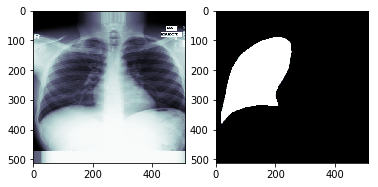

In [152]:
plt.subplot(1,2,1)
plt.imshow(image[:,:,0], cmap="bone")
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0], cmap="bone")

In [60]:
image.shape

(512, 512, 1)

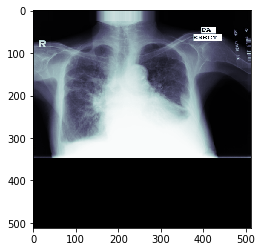

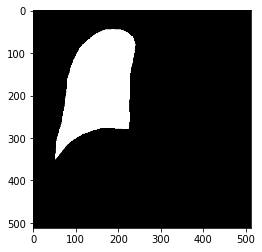

In [154]:
train_gen = getTrainData()
val_gen = getValData()

history = model.fit_generator(train_gen,
                              steps_per_epoch=8,
                              epochs=40,
                              callbacks=[model_checkpoint], validation_data=val_gen, validation_steps=2)

Epoch 1/40
Found 42 images belonging to 1 classes.
Found 96 images belonging to 1 classes.
Found 42 images belonging to 1 classes.
Found 96 images belonging to 1 classes.
8/8 [==============================] - ETA: 16s - loss: 0.7543 - dice_coef: 0.2457 - binary_accuracy: 0.32 - ETA: 11s - loss: 0.7560 - dice_coef: 0.2440 - binary_accuracy: 0.32 - ETA: 8s - loss: 0.7550 - dice_coef: 0.2450 - binary_accuracy: 0.3152 - ETA: 6s - loss: 0.7655 - dice_coef: 0.2345 - binary_accuracy: 0.345 - ETA: 4s - loss: 0.7701 - dice_coef: 0.2299 - binary_accuracy: 0.343 - ETA: 3s - loss: 0.7745 - dice_coef: 0.2255 - binary_accuracy: 0.339 - ETA: 1s - loss: 0.7786 - dice_coef: 0.2214 - binary_accuracy: 0.344 - 12s 2s/step - loss: 0.7815 - dice_coef: 0.2185 - binary_accuracy: 0.3445 - val_loss: 1.0000 - val_dice_coef: 9.5711e-07 - val_binary_accuracy: 0.9993

Epoch 00001: loss did not improve from 0.75581
Epoch 2/40
8/8 [==============================] - ETA: 6s - loss: 0.8156 - dice_coef: 0.1844 - binary


Epoch 00011: loss did not improve from 0.75581
Epoch 12/40
8/8 [==============================] - ETA: 5s - loss: 0.7843 - dice_coef: 0.2157 - binary_accuracy: 0.311 - ETA: 6s - loss: 0.7865 - dice_coef: 0.2135 - binary_accuracy: 0.317 - ETA: 6s - loss: 0.7744 - dice_coef: 0.2256 - binary_accuracy: 0.336 - ETA: 4s - loss: 0.7802 - dice_coef: 0.2198 - binary_accuracy: 0.367 - ETA: 3s - loss: 0.7769 - dice_coef: 0.2231 - binary_accuracy: 0.363 - ETA: 2s - loss: 0.7729 - dice_coef: 0.2271 - binary_accuracy: 0.360 - ETA: 1s - loss: 0.7750 - dice_coef: 0.2250 - binary_accuracy: 0.355 - 10s 1s/step - loss: 0.7768 - dice_coef: 0.2232 - binary_accuracy: 0.3570 - val_loss: 1.0000 - val_dice_coef: 1.5510e-06 - val_binary_accuracy: 1.0000

Epoch 00012: loss did not improve from 0.75581
Epoch 13/40
8/8 [==============================] - ETA: 7s - loss: 0.7738 - dice_coef: 0.2262 - binary_accuracy: 0.339 - ETA: 7s - loss: 0.7712 - dice_coef: 0.2288 - binary_accuracy: 0.314 - ETA: 6s - loss: 0.7711

8/8 [==============================] - ETA: 5s - loss: 0.8015 - dice_coef: 0.1985 - binary_accuracy: 0.705 - ETA: 6s - loss: 0.7738 - dice_coef: 0.2262 - binary_accuracy: 0.697 - ETA: 5s - loss: 0.7860 - dice_coef: 0.2140 - binary_accuracy: 0.698 - ETA: 4s - loss: 0.7797 - dice_coef: 0.2203 - binary_accuracy: 0.692 - ETA: 3s - loss: 0.7811 - dice_coef: 0.2189 - binary_accuracy: 0.693 - ETA: 2s - loss: 0.7761 - dice_coef: 0.2239 - binary_accuracy: 0.695 - ETA: 1s - loss: 0.7767 - dice_coef: 0.2233 - binary_accuracy: 0.705 - 10s 1s/step - loss: 0.7739 - dice_coef: 0.2261 - binary_accuracy: 0.7125 - val_loss: 1.0000 - val_dice_coef: 1.0666e-06 - val_binary_accuracy: 1.0000

Epoch 00023: loss did not improve from 0.75581
Epoch 24/40
8/8 [==============================] - ETA: 6s - loss: 0.7487 - dice_coef: 0.2513 - binary_accuracy: 0.733 - ETA: 6s - loss: 0.7637 - dice_coef: 0.2363 - binary_accuracy: 0.721 - ETA: 5s - loss: 0.7695 - dice_coef: 0.2305 - binary_accuracy: 0.708 - ETA: 4s - lo

8/8 [==============================] - ETA: 5s - loss: 0.5642 - dice_coef: 0.4358 - binary_accuracy: 0.719 - ETA: 6s - loss: 0.5747 - dice_coef: 0.4253 - binary_accuracy: 0.736 - ETA: 5s - loss: 0.5902 - dice_coef: 0.4098 - binary_accuracy: 0.723 - ETA: 4s - loss: 0.5732 - dice_coef: 0.4268 - binary_accuracy: 0.728 - ETA: 3s - loss: 0.5642 - dice_coef: 0.4358 - binary_accuracy: 0.739 - ETA: 2s - loss: 0.5509 - dice_coef: 0.4491 - binary_accuracy: 0.748 - ETA: 1s - loss: 0.5450 - dice_coef: 0.4550 - binary_accuracy: 0.760 - 10s 1s/step - loss: 0.5414 - dice_coef: 0.4586 - binary_accuracy: 0.7652 - val_loss: 0.9997 - val_dice_coef: 2.6192e-04 - val_binary_accuracy: 0.9995

Epoch 00033: loss improved from 0.58331 to 0.54140, saving model to unet_lung_seg.hdf5
Epoch 34/40
8/8 [==============================] - ETA: 6s - loss: 0.6410 - dice_coef: 0.3590 - binary_accuracy: 0.757 - ETA: 6s - loss: 0.6018 - dice_coef: 0.3982 - binary_accuracy: 0.762 - ETA: 6s - loss: 0.5910 - dice_coef: 0.4090

In [63]:
test_datagen = ImageDataGenerator(rescale=1./255)




test_image_generator = test_datagen.flow_from_directory(
    TEST_FRAME_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode=None,
    batch_size = BATCH_SIZE)


test_mask_generator = test_datagen.flow_from_directory(
    TEST_MASK_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode=None,
    batch_size = BATCH_SIZE)

train_generator = zip(train_image_generator, train_mask_generator)

Found 96 images belonging to 1 classes.
Found 96 images belonging to 1 classes.
Found 42 images belonging to 1 classes.
Found 42 images belonging to 1 classes.


In [99]:
def get_data(framePath, maskPath, train=True):
    ids = next(os.walk(framePath))[2]
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(os.path.join(framePath, id_), grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(os.path.join(maskPath, id_), grayscale=True))
            mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    


In [7]:
def preprocessImage(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize_images(image, [IMG_HEIGHT, IMG_WIDTH])
    image /= 255.0
    
    return image

def loadAndPreprocessImage(path):
    image = tf.read_file(path)
    return preprocessImage(image)

def plotImageLabelPairs(imageLabelDs, numPairs=4):
    for i, (image, mask) in enumerate(imageLabelDs.take(numPairs)):
        plt.figure(figsize=(8,12))
        plt.subplot(4,2,2*i+1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4,2,2*i+2)
        plt.imshow(mask)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

In [15]:
images = [os.path.join(TRAIN_FRAME_PATH, x) for x in os.listdir(TRAIN_FRAME_PATH)]
masks = [os.path.join(TRAIN_MASK_PATH, x) for x in os.listdir(TRAIN_MASK_PATH)]

valImages = [os.path.join(TRAIN_FRAME_PATH, x) for x in os.listdir(TEST_FRAME_PATH)]
valMasks = [os.path.join(TRAIN_MASK_PATH, x) for x in os.listdir(TEST_MASK_PATH)]

In [16]:
path_ds = tf.data.Dataset.from_tensor_slices(images)
mask_ds = tf.data.Dataset.from_tensor_slices(masks)
image_ds = path_ds.map(loadAndPreprocessImage, num_parallel_calls=AUTOTUNE)
label_ds = mask_ds.map(loadAndPreprocessImage, num_parallel_calls=AUTOTUNE)

val_path_ds = tf.data.Dataset.from_tensor_slices(valImages)
val_mask_ds = tf.data.Dataset.from_tensor_slices(valMasks)
val_image_ds = val_path_ds.map(loadAndPreprocessImage, num_parallel_calls=AUTOTUNE)
val_label_ds = val_mask_ds.map(loadAndPreprocessImage, num_parallel_calls=AUTOTUNE)


In [17]:
dt_lbl_ds = tf.data.Dataset.zip((image_ds, label_ds))
val_dt_lbl_ds = tf.data.Dataset.zip((val_image_ds, val_label_ds))

In [51]:
image = loadAndPreprocessImage(getRandomImagePathFrom(TRAIN_FRAME_PATH))

In [127]:
next(os.walk(TEST_FRAME_PATH))[1]

['1']

In [155]:
#X, y = get_data(TRAIN_FRAME_PATH+"\\1", TRAIN_MASK_PATH+"\\1", train=True)
Xt, yt = get_data(TEST_FRAME_PATH+"\\1", TEST_MASK_PATH+"\\1", train=True)

Getting and resizing images ... 


c:\users\wojtek\appdata\local\conda\conda\envs\deep learning\lib\site-packages\keras_preprocessing\image\utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [14]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(dt_lbl_ds, epochs=100, callbacks=callbacks)

In [ ]:
results.validation_data

In [ ]:
model.load_weights('model-tgs-salt.h5')

In [ ]:
model.evaluate(Xt, yt, verbose=1)

In [106]:
preds_train

[]

In [156]:
Xt = Xt[1:3,:,:,:]
yt = yt[1:3,:,:,:]

In [157]:
preds_train = model.predict(Xt, verbose=1)
preds_val = model.predict(yt, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

2/2 [==============================] - 0s 36ms/step


In [159]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='binary')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors=['black', 'white'], levels=[0.5])
    ax[0].set_title('RTG')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Left Lung')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors=['black', 'white'], levels=[0.5])
    ax[2].set_title('Predicted Lung')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted Lung Binary');

In [141]:
preds_train.shape

(2, 512, 512, 1)

Text(0.5, 1.0, 'Recognized as binary')

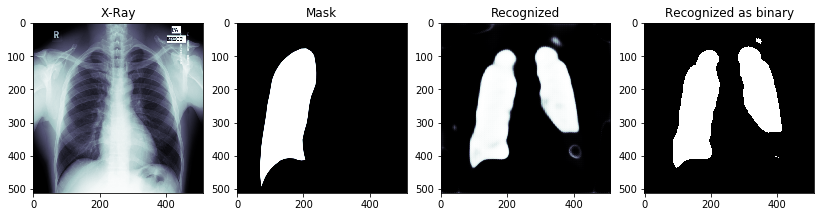

In [168]:
plt.figure(figsize=(14,9))
plt.subplot(1, 4, 1)
plt.imshow(Xt[1,:,:,0], cmap='bone')
plt.title("X-Ray")
plt.subplot(1, 4, 2)
plt.imshow(yt[1,:,:,0], cmap='bone')
plt.title("Mask")
plt.subplot(1, 4, 3)
plt.imshow(preds_train[1,:,:,0], cmap='bone')
plt.title("Recognized")
plt.subplot(1, 4, 4)
plt.imshow(preds_train_t[1,:,:,0], cmap='bone')
plt.title("Recognized as binary")


In [160]:
plot_sample(X, y, preds_train, preds_train_t)

IndexError: index 0 is out of bounds for axis 0 with size 0